In [1]:
# https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/ - IBUG dataset
# https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/?_ga=2.191050858.1913902486.1642077624-847301844.1639919914 - face recognition tutorial
# https://github.com/davisking/dlib-models#shape_predictor_68_face_landmarksdatbz2 - facial landmarks models
# https://github.com/rizkiarm/LipNet - LipNet - Github

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import dlib
import cv2

In [3]:
class VideoReader:
    def __init__(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            # convert the image to grey scale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray)
        cap.release()
        frames = np.array(frames)
        self.frames = frames
        self.video_tensor = torch.Tensor(frames)

    def get_tensor(self):
        return self.video_tensor

    def get_frames(self):
        return self.frames

In [4]:
class Padding:
    def __init__(self, method, h_pad, v_pad):
        self.method = method
        self.h_pad = h_pad
        self.v_pad = v_pad

    def pad(self, np_points):

        xs=np_points[:, :-1]
        ys=np_points[:, 1:]

        centroid = np.mean(np_points, axis=0)

        min_x = np.min(xs)
        max_x = np.max(xs)
        min_y = np.min(ys)
        max_y = np.max(ys)

        if self.method=='no-pad':
            left = min_x
            right = max_x
            top = min_y
            bottom = max_y

        if self.method=='precentage-padding':
            left = min_x * (1.0 - self.h_pad)
            right = max_x * (1.0 + self.h_pad)
            top = min_y * (1.0 - self.v_pad)
            bottom = max_y * (1.0 + self.v_pad)
            
        if self.method=='pixel-padding':
            left = min_x - self.h_pad
            right = max_x + self.h_pad
            top = min_y - self.v_pad
            bottom = max_y + self.v_pad

        if self.method=='fixed-size-padding':
            left = centroid[0] - self.h_pad / 2
            right = centroid[0] + self.h_pad / 2
            top = centroid[1] - self.v_pad / 2
            bottom = centroid[1] + self.v_pad / 2

        return int(left), int(right), int(top), int(bottom)


In [5]:
class Video:
    def __init__(self, video_path):

        self.face_predictor_path = '/content/shape_predictor_68_face_landmarks.dat'
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(self.face_predictor_path)

        self.video_path = video_path
        self.frames = self._frames_from_video()
        self.mouth_frames = self._get_mouth_frames()
        

    def _frames_from_video(self):
        reader = VideoReader(path=self.video_path)
        frames = reader.get_frames()
        return frames

    def _get_mouth_frames(self, verbose=False):
        MOUTH_WIDTH = 80
        MOUTH_HEIGHT = 50

        # padding options.
        # currently the fixed-size-padding padding is used.
        padding = Padding(method='no-pad', h_pad=0, v_pad=0)
        padding = Padding(method='precentage-padding', h_pad=0.15, v_pad=0.15)
        padding = Padding(method='pixel-padding', h_pad=10, v_pad=10)
        padding = Padding(method='fixed-size-padding', h_pad=MOUTH_WIDTH, v_pad=MOUTH_HEIGHT) # creates lips with the form: width=h_pad, height=v_pad

        mouth_frames = []
        for frame in self.frames:
            mouth_crop_image = self._find_mouth(frame, padding, verbose)
            mouth_frames.append(mouth_crop_image)
        
        return mouth_frames

    def _find_mouth(self, frame, padding, verbose=False):
        rects = self.detector(frame,1)
        shape = None
        for rect in rects:
            shape = self.predictor(frame, rect) # shape.parts() is 68 (x,y) points
        if shape is None:  # Detector doesn't detect face, just return as is
            print("Detector doesn't detect face")
            return frame

        mouth_points = [(part.x, part.y) for part in shape.parts()[48:]] # points 48-64 indicate the mouth region
        np_mouth_points = np.array(mouth_points)

        mouth_left, mouth_right, mouth_top, mouth_bottom = padding.pad(np_mouth_points)
        mouth_crop_image = frame[mouth_top:mouth_bottom, mouth_left:mouth_right]
        if verbose:
            print(mouth_left, mouth_right, mouth_top, mouth_bottom)
        return mouth_crop_image

    def plot_random_lips(self):
        frame_index = random.randrange(len(self.frames))
        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
        axs[0].imshow(self.frames[frame_index], cmap='gray')
        axs[0].set_title('Original Frame')
        axs[1].imshow(self.mouth_frames[frame_index], cmap='gray')
        axs[1].set_title('Lips Crop')

    def __repr__(self):
        try:
            mouth_frames_shape = np.array(self.mouth_frames)[0].shape
        except:
            mouth_frames_shape = 'unequal'
        return f'frames shape: {self.frames.shape}\n' + f'mouth frames: {len(self.mouth_frames)}, frame shape: {mouth_frames_shape}'
        

In [6]:
%%time
video_path = '/content/id2_vcd_swwp2s.mpg'
video = Video(video_path)

CPU times: user 6.16 s, sys: 195 ms, total: 6.35 s
Wall time: 6.29 s


In [7]:
video

frames shape: (75, 288, 360)
mouth frames: 75, frame shape: (50, 80)

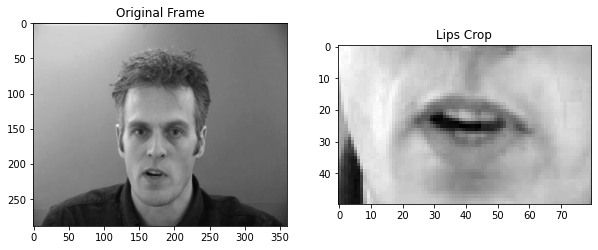

In [12]:
video.plot_random_lips()